#EOSIO Electorate Research App#
Andreu Taranu
<br>admin@autonet.ai





# [Watch the video walkthrough](https://www.youtube.com/watch?v=fOh5pUpwkMM)

Install python client for calling the EOS API

In [ ]:
!pip3 install git+https://github.com/eosnewyork/eospy.git

  Cloning https://github.com/eosnewyork/eospy.git to /tmp/pip-req-build-22ia4sp9
  Running command git clone -q https://github.com/eosnewyork/eospy.git /tmp/pip-req-build-22ia4sp9
     |████████████████████████████████| 102kB 2.2MB/s 
     |████████████████████████████████| 122kB 10.7MB/s 
  Created wheel for libeospy: filename=libeospy-2.0.1-cp36-none-any.whl size=26858 sha256=5abedfc8ac3938c09ab4ab0137ac61fc670d70398e57fe145f8232b1d5f3a946
  Stored in directory: /tmp/pip-ephem-wheel-cache-zq12ffat/wheels/e2/f6/17/54de032a395dd59c5af8367523c307d463880df8bbd8331f10
Successfully built libeospy


In [ ]:
from eospy import cleos
import pandas as pd
api=cleos.Cleos(url="http://bp.cryptolions.io")

In [ ]:
m=api.get_producers(limit=100)
m['total_producer_vote_weight']

'186033584670054088704.00000000000000000'

In [ ]:
prods=pd.DataFrame(columns=["account","eos","url","location","nodes"])

In [ ]:
#fill in dataframe
from requests import get
import json
for i in range (100):
  account=m['rows'][i]['owner']
  eos=m['rows'][i]['total_votes']
  url=m['rows'][i]['url']
  #each producer has a json file with additional info
  try:
      nse=get(url+"/bp.json")
    geison=json.loads(response.text)
    nodes=len(geison['nodes'])
    location=geison['org']['location']['country']
    prods.loc[i]={"account":account,"eos":eos,"url":url,"location":location,"nodes":nodes}
    print(prods.loc[i])
  except:
    prods.loc[i]={"account":account,"eos":eos,"url":url,"location":0,"nodes":1}

In [ ]:
prods.head()

,account,eos,url,location,nodes
0,eosnationftw,5061130129338967040.00000000000000000,https://eosnation.io,CA,3
1,eoseouldotio,5028257910704562176.00000000000000000,https://www.eoseoul.io,KR,3
2,big.one,5024964070451013632.00000000000000000,https://eos.big.one,CN,1
3,eosdotwikibp,4975230937084326912.00000000000000000,https://eos.wiki,KY,3
4,okcapitalbp1,4967877151581706240.00000000000000000,https://www.okex.com/eosbp/,CN,3


Add relevant categories to dataframe

In [ ]:
cats=["jurisdiction","team","content volume","followers","crypto-activism","community","developer","cores","ram","storage","green","staking"]
for cat in newcats:
  prods[cat]=prods['nodes'].mul(0)

Export to a file and fill in the chart with appropriate values

In [ ]:
prods.to_csv("prods.csv")

Make a 'voters' DataFrame and call the API to get the rows. Each row will have a name (owner), a staked amount (eos) and an array of chosen candidates (producers).

In [ ]:
voters=pd.DataFrame(columns=["account",'eos','producers'])
lowerBound=''
count=0
while(lowerBound[0:6]!="zzzzzz"):
    v=api.get_table(table='voters',scope='eosio',code="eosio", limit=35000,lower_bound=lowerBound)
    for voter in v['rows']:
        lowerBound=voter['owner']
        if len(voter['producers'])>0:
            count=count+1
            account=voter['owner']
            eos=voter['last_vote_weight']
            producers=voter['producers']
            voters.loc[count]={"account":account,"eos":eos,"producers":producers}
            # print(account," is voting with ",eos, " for ",producers)
    print("Total voters ",count, "lower bound= ",lowerBound)

Reimport the producers dataframe and fill the missing values with zero

In [ ]:
prods=pd.read_csv("drive/My Drive/ERA/prods.csv")
prods.fillna(0, inplace=True)

In [ ]:
#normalize between 0 and 9
def normalize(value,oldmax,oldmin):
  return ((value-oldmin)*9)/(oldmax-oldmin)

#Calculate individual voter preferences#
For each voter, go through the list of the BPs that they voted for and add up the feature scores.<br>

**Run as separate python file to enable multiprocess**

In [ ]:
from multiprocessing import Process

prods=pd.read_csv('prods.csv')
prods.fillna(0,inplace=True)
voters=pd.read_csv('voters')
for cat in cats:
  voters[cat]=voters['eos'].mul(0)

def add_prefs(start,voterz):
    for i in range(start,start+863):
        voterz.at[i,"account"]=voters.at[i,"account"]
        voterz.at[i,"eos"]=voters.at[i,"eos"]
        voterz.at[i,"producers"]=voters.at[i,"producers"]
        for cat in cats:
            category=0
            for prod in voters.loc[i]['producers'].split("'")[1::2]:
                if prod in prods.values:
                    category=category+int(prods[prods['account']==prod][cat].array[0])   
            voterz.at[i,cat]=category
        if i%25==0:
            print (voterz.loc[i])
    voterz.to_csv("voterz"+str(start)+".csv")

if __name__ == '__main__':
    print("program started")
    procs=[]
    counter=0
    voterz=pd.DataFrame(columns=voters.columns.values)
    for i in range(50):
        procs.append(Process(target=add_prefs, args=(counter,voterz)))
        counter=counter+863
    for proc in procs:
        proc.start()
    for proc in procs:
        proc.join()
    frames=[]
    m=0
    for i in range(50):
        frames.append(pd.read_csv("voterz"+str(m)+".csv"))
        m=m+863
    voterz=pd.concat(frames)
    voterz.to_csv("voterz.csv")
    print("program end")

In [ ]:
voters.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,account,eos,producers,jurisdiction,team,content volume,followers,crypto-activism,community,developer,cores,ram,storage,green,staking
0,0,0,NaN,...........n,1.048576e+06,['bitfinexeos1'],3,0,3,1249,0,4,0,96,1500,2000,1,1
1,1,1,NaN,111111111132,0.000000e+00,"['alohaeosprod', 'aus1genereos', 'blockmatrix1...",46,36,89,34062,2,47,25,222,3000,103152,3,2
2,2,2,NaN,111111111133,6.211353e+10,"['eosasia11111', 'eosauthority', 'eosbeijingbp...",12,14,14,8705,4,9,5,276,1400,84100,1,1
3,3,3,NaN,111111111134,0.000000e+00,"['aus1genereos', 'blockchained', 'blocksmithio...",37,17,77,48829,0,36,21,222,2680,103152,2,2
4,4,4,NaN,111111111152,0.000000e+00,"['aus1genereos', 'blockchained', 'btccpooleos1...",37,25,40,49751,9,46,17,184,6224,112540,2,2


Get preferences for the entire electorate

In [ ]:
prefs={}
for cat in cats:
  prefs[cat]=normalize(voters[cat].mean(),voters[cat].max(),voters[cat].min())
for cat in cats:
    wcat="w"+cat
    voters[wcat]=voters['eos'].mul(0)

Calculate weighted preferences for the entire electorate

In [ ]:
#multiply voter preferences by the amount staked on the vote
for i in range(voters.shape[0]):
    for cat in cats:
        voters.at[i,"w"+cat]=voters.at[i,cat]*voters.at[i,"eos"]
    if i%1000==0:
        print("i is: ",i)
wprefs={}
for cat in cats:
  wprefs["w"+cat]=normalize(voters["w"+cat].mean(),voters["w"+cat].max(),voters["w"+cat].min())*900

Create the lists of values and labels to plot

In [ ]:
values=prefs.values()
labes=prefs.keys()
labes2=wprefs.keys()
wvalues=wprefs.values()

Plot the values on pie charts

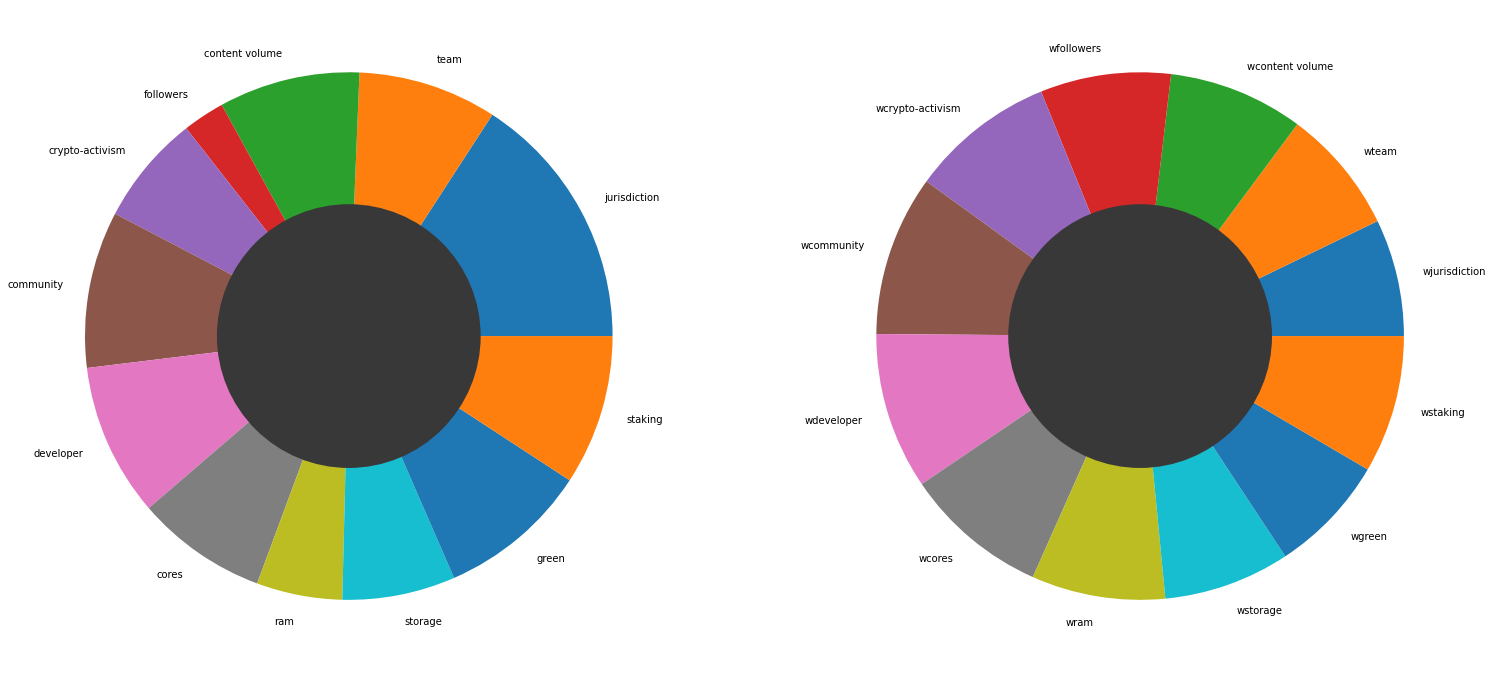

In [ ]:
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.pie(values, labels=labes)
plt.title="Voter Preferences Unweighted"
circle=plt.Circle(xy=(0,0),radius=0.5,facecolor="#383838")
plt.gca().add_artist(circle)
plt.subplot(1,2,2)
plt.pie(wvalues, labels=labes2)
plt.title="Voter Preferences Weighted"
plt.rcParams["figure.figsize"] = [26,26]
circle=plt.Circle(xy=(0,0),radius=0.5, facecolor="#383838")
plt.gca().add_artist(circle)
plt.show()

Function to get Enclidian distance in multi-dimentional space

In [ ]:
import math
def getDistanceBetween(them,us):
  total=0
  for i in range(len(them)):
    if them[i]-us[i]>0:
      us[i]=them[i]
    total+=(them[i]-us[i])**2
  distance=abs(math.sqrt(total))
  return distance

Function to estimate electorate reaction to any given configuration of features

In [ ]:
def success (us,tolerance):
  print ("started")
  eos=0
  thevoters=[]
  for i in range (voters.shape[0]):
    features=[]
    for cat in cats:
      features.append(voters.iloc[i][cat])
    distance=getDistanceBetween(us,features)
    if distance<tolerance:
      thevoters.append(voters.iloc[i]['account'])
      eos=eos+(voters.iloc[i]['eos']/len(voters.iloc[i]['producers'].split("'")[1::2]))
  return [eos,thevoters]

##Run simulation##

In [ ]:
#@title Predict votes on feature set
jurisdiction = 6 #@param {type:"slider", min:0, max:9, step:1}
geodiv = 3 #@param{type:"slider",min:0,max:9,step:1}
team = 7#@param{type:"slider",min:0,max:9,step:1}
followers = 6 #@param{type:"slider",min:0,max:9,step:1}
content = 6 #@param{type:"slider",min:0,max:9,step:1}
developer = 8 #@param{type:"slider",min:0,max:9,step:1}
activism = 3 #@param{type:"slider",min:0,max:9,step:1}
cores=7 #@param {type:"integer"}
ram=0 #@param{type:"number"}
storage=0 #@param{type:"number"}
staking=True #@param {type:"boolean"}
green=True #@param {type:"boolean"}

result=success([jurisdiction,geodiv,team,followers,developer,content,activism,
                cores,ram,storage,staking,green],2)
print ("got ",result[0]," from ",len(result[1])," votes.")

for i in range(prods.shape[0]):
  if result[0]>prods.at[i,'eos']:
    print ("Rank: ",i)
    break
  if result[0]<prods.at[99,"eos"]:
    print("Not in top 100")

started
got  3.645348619389351e+16  from  14883  votes.
Rank:  82


Webapp with the same functionality available [here](http://3.21.64.250/).
To get access to all tabs hit F7 and input "password".
